## **Import Library**

In [1]:
import os
import random
import shutil
import hashlib
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_recall_curve, roc_curve, auc, precision_score, recall_score, roc_auc_score
from PIL import Image


# **Data Preprocessing and Data Split**

The provided dataset contains two files, 'gender' and 'gender_rev2'. The image data in both files are data segmented by the author. The authors split it into three files 'test', 'train', and 'valid'. Each file contains two categories, 'male' and 'female'. There were a total of 3891 files. To make the data more adaptable with the task in this study. First I contained an 'Image_Datasets' file, which created an 'original_dataset' file. 'original_dataset' file contains two empty files for 'male' and 'female'. Then I took the author's 3891 image files and put them into the male and female files. Also I used the author's 'image to predict' file to test the actual recognition ability of the model. After that start this experiment.
Datasets URL:https://www.kaggle.com/datasets/gpiosenka/gender-classification-from-an-image 

    Data Checking and Cleaning 

Found 3891 images belonging to 2 classes.
Class labels:
 - female: 0
 - male: 1
Number of samples per class: {'female': 1947, 'male': 1944}
Most common resolution: [ 84 109]
No issues found in the dataset.


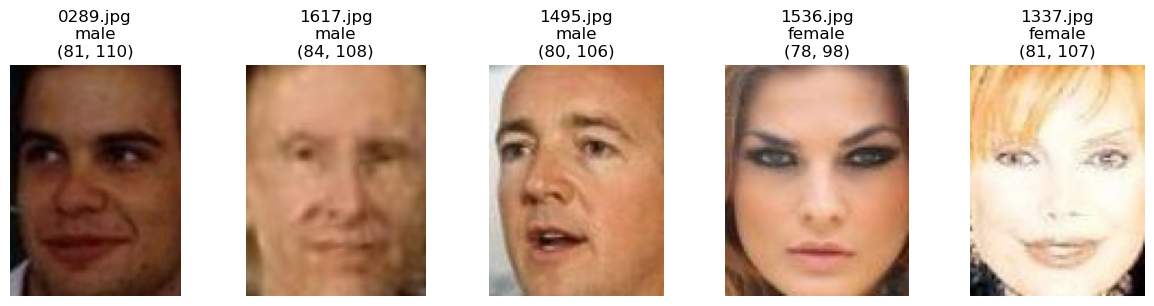

In [ ]:

def analyze_dataset(data_cleaning_path):
    datagen = ImageDataGenerator()
    data_flow = datagen.flow_from_directory(data_cleaning_path, target_size=(256, 256), class_mode='binary')
    class_indices = data_flow.class_indices
    classes = list(class_indices.keys())
    num_classes = len(classes)
    class_counts = {}
    resolutions = []
    for class_name in classes:
        class_path = os.path.join(data_cleaning_path, class_name)
        class_counts[class_name] = 0

        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            try:
                with Image.open(image_path) as img:
                    resolutions.append(img.size) 
                    class_counts[class_name] += 1
            except IOError:
                print(f"Cannot open image: {image_path}")
    resolutions = np.array(resolutions)
    unique_resolutions, counts = np.unique(resolutions, axis=0, return_counts=True)
    most_common_resolution = unique_resolutions[np.argmax(counts)]

    print("Class labels:")
    for class_name, label in class_indices.items():
        print(f" - {class_name}: {label}")

    return class_counts, most_common_resolution

def get_image_hash(image_path):
    with open(image_path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

def check_corrupted(image_path):
    try:
        with Image.open(image_path) as img:
            img.verify()
        return False
    except (IOError, SyntaxError):
        return True

def check_dataset(directory):
    hashes = set()
    class_counts = {}
    issues_found = False

    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue

        class_counts[class_name] = 0

        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)

         
            image_hash = get_image_hash(image_path)
            if image_hash in hashes:
                print(f"Duplicate image found: {image_path}")
                issues_found = True
                continue
            hashes.add(image_hash)

   
            if check_corrupted(image_path):
                print(f"Corrupted image found: {image_path}")
                issues_found = True
                continue

            class_counts[class_name] += 1
    min_count = min(class_counts.values())
    max_count = max(class_counts.values())
    if max_count > 1.5 * min_count: 
        print("Class imbalance detected.")
        issues_found = True

    return issues_found

def display_sample_images_with_info(directory, num_images=5):
    images = []
    labels = []

    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue

        image_files = os.listdir(class_path)
        images += [os.path.join(class_path, file) for file in image_files]
        labels += [class_name for _ in image_files]

    selected_indices = random.sample(range(len(images)), num_images)
    sample_images = [images[i] for i in selected_indices]
    sample_labels = [labels[i] for i in selected_indices]

    plt.figure(figsize=(15, 3))
    for i, image_path in enumerate(sample_images):
        img = Image.open(image_path)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(os.path.basename(image_path)+'\n'+f'{sample_labels[i]}\n{img.size}')
        plt.axis('off')
    
    plt.show()

data_cleaning_path = 'Image_Datasets/Original_Dataset'  
class_counts, most_common_resolution = analyze_dataset(data_cleaning_path)

print("Number of samples per class:", class_counts)
print("Most common resolution:", most_common_resolution)
if not check_dataset(data_cleaning_path):
    print("No issues found in the dataset.")
display_sample_images_with_info(data_cleaning_path)


    Data augmentation

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

def copy_original_images(source_dir, target_dir, class_name):

    source_class_dir = os.path.join(source_dir, class_name)
    target_class_dir = os.path.join(target_dir, class_name)

    if not os.path.exists(target_class_dir):
        os.makedirs(target_class_dir)

    for filename in os.listdir(source_class_dir):
        source_path = os.path.join(source_class_dir, filename)
        target_path = os.path.join(target_class_dir, filename)
        shutil.copy2(source_path, target_path)

def augment_images(source_dir, class_name, target_dir, target_count, generator):

    source_class_dir = os.path.join(source_dir, class_name)
    target_class_dir = os.path.join(target_dir, class_name)
    
    if not os.path.exists(target_class_dir):
        os.makedirs(target_class_dir)

    current_count = len(os.listdir(source_class_dir))
    required_count = target_count - current_count
    print(f"{class_name}: There ara currently {current_count} images, and {required_count} images need to be enhanced.")

    if required_count <= 0:
        print(f"{class_name}: The target number has been reached and no enhancement is required.")
        return

    flow = generator.flow_from_directory(
        directory=source_dir,
        classes=[class_name],
        target_size=(120, 100),
        batch_size=32,
        class_mode='categorical',  
        save_to_dir=target_class_dir,
        save_prefix='aug_',
        save_format='png'
    )

    num_batches = required_count // 32 + (1 if required_count % 32 > 0 else 0)
    for i in range(num_batches):
        next(flow)
        if len(os.listdir(target_class_dir)) >= target_count:
            break

original_dataset_dir = 'Image_Datasets/original_dataset'
augmented_dataset_dir = 'Image_Datasets/augmented_dataset'

for class_name in ['female', 'male']:
    copy_original_images(original_dataset_dir, augmented_dataset_dir, class_name)

for class_name in ['female', 'male']:
    augment_images(original_dataset_dir, class_name, augmented_dataset_dir, 5000, datagen)

print("Done!")


female: There ara currently 1947 images, and 3053 images need to be enhanced.
Found 1947 images belonging to 1 classes.
male: There ara currently 1944 images, and 3056 images need to be enhanced.
Found 1944 images belonging to 1 classes.
Done!


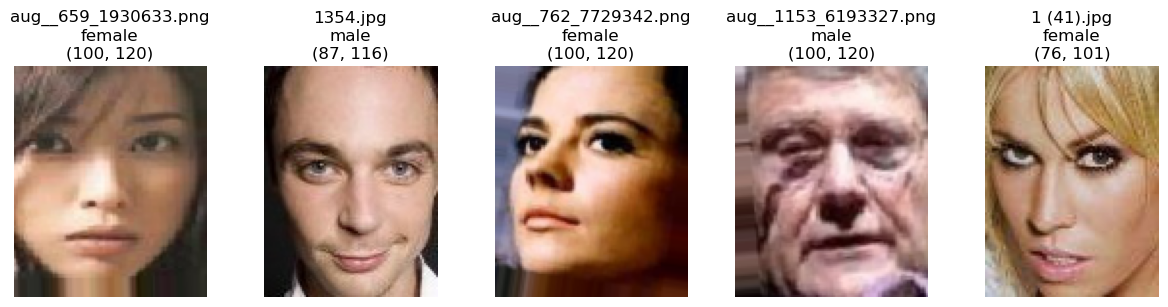

In [ ]:
data_dir = 'Image_Datasets/augmented_dataset'  

def display_sample_images_with_info_after_augmentation(directory, num_images=5):
    images = []
    labels = []

    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue

        image_files = os.listdir(class_path)
        images += [os.path.join(class_path, file) for file in image_files]
        labels += [class_name for _ in image_files]

    selected_indices = random.sample(range(len(images)), num_images)
    sample_images = [images[i] for i in selected_indices]
    sample_labels = [labels[i] for i in selected_indices]

    plt.figure(figsize=(15, 3))
    for i, image_path in enumerate(sample_images):
        img = Image.open(image_path)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(os.path.basename(image_path)+'\n'+f'{sample_labels[i]}\n{img.size}')
        plt.axis('off')
    
    plt.show()
display_sample_images_with_info_after_augmentation(data_dir)

    Data Split

In [ ]:
def split_dataset(original_dir, target_dir, train_ratio=0.8, val_ratio=0.1):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
        os.makedirs(os.path.join(target_dir, 'train'))
        os.makedirs(os.path.join(target_dir, 'validation'))
        os.makedirs(os.path.join(target_dir, 'test'))

    classes = [d for d in os.listdir(original_dir) if os.path.isdir(os.path.join(original_dir, d))]

    for cls in classes:
        os.makedirs(os.path.join(target_dir, 'train', cls))
        os.makedirs(os.path.join(target_dir, 'validation', cls))
        os.makedirs(os.path.join(target_dir, 'test', cls))

        all_images = os.listdir(os.path.join(original_dir, cls))
        np.random.shuffle(all_images)

        train_end = int(len(all_images) * train_ratio)
        val_end = train_end + int(len(all_images) * val_ratio)

        for i, img in enumerate(all_images):
            if i < train_end:
                subset = 'train'
            elif i < val_end:
                subset = 'validation'
            else:
                subset = 'test'

            src = os.path.join(original_dir, cls, img)
            dst = os.path.join(target_dir, subset, cls, img)
            shutil.copy(src, dst)

def count_images_in_subfolders(directory):
    counts = {}
    for subset in ['train', 'validation', 'test']:
        subset_path = os.path.join(directory, subset)
        for cls in os.listdir(subset_path):
            class_path = os.path.join(subset_path, cls)
            if os.path.isdir(class_path):
                count = len(os.listdir(class_path))
                counts[f"{subset}/{cls}"] = count
    return counts


augmented_dataset_dir = "Image_Datasets/augmented_dataset"
splited_dataset_dir = "Image_Datasets/splited_dataset"

split_dataset(augmented_dataset_dir, splited_dataset_dir)

train/female: 4036 images
train/male: 4032 images
validation/female: 504 images
validation/male: 504 images
test/female: 506 images
test/male: 504 images


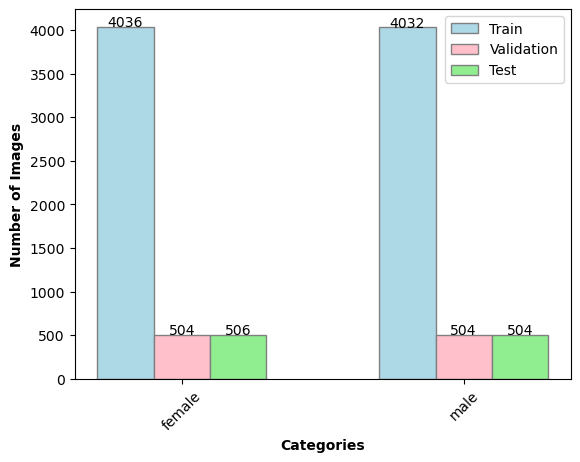

In [ ]:
counts = count_images_in_subfolders(splited_dataset_dir)
for key, count in counts.items():
    print(f"{key}: {count} images")

def visualize_data_splits(train_dir, validation_dir, test_dir):
    categories = set()
    data = {'train': {}, 'validation': {}, 'test': {}}

    for dataset, directory in zip(['train', 'validation', 'test'], [train_dir, validation_dir, test_dir]):
        for category in os.listdir(directory):
            category_path = os.path.join(directory, category)
            if os.path.isdir(category_path):
                categories.add(category)
                data[dataset][category] = len(os.listdir(category_path))

    categories = sorted(list(categories))
    
    bar_width = 0.2
    r1 = np.arange(len(categories))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    plt.bar(r1, [data['train'].get(category, 0) for category in categories], color='#ADD8E6', width=bar_width, edgecolor='grey', label='Train')
    plt.bar(r2, [data['validation'].get(category, 0) for category in categories], color='#FFC0CB', width=bar_width, edgecolor='grey', label='Validation')
    plt.bar(r3, [data['test'].get(category, 0) for category in categories], color='#90EE90', width=bar_width, edgecolor='grey', label='Test')

    plt.xlabel('Categories', fontweight='bold')
    plt.ylabel('Number of Images', fontweight='bold')
    plt.xticks([r + bar_width for r in range(len(categories))], categories, rotation=45)
    plt.legend()

    def add_labels(r, dataset):
        for i in range(len(categories)):
            plt.text(x=r[i], y=data[dataset][categories[i]] + 5, s=data[dataset][categories[i]], ha='center')

    add_labels(r1, 'train')
    add_labels(r2, 'validation')
    add_labels(r3, 'test')

    plt.show()

splited_dataset_dir = "Image_Datasets/splited_dataset"
train_dir = os.path.join(splited_dataset_dir, 'train')
validation_dir = os.path.join(splited_dataset_dir, 'validation')
test_dir = os.path.join(splited_dataset_dir, 'test')

visualize_data_splits(train_dir, validation_dir, test_dir)


    Data Preprocessing

In [2]:
def preprocess_data():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    val_test_datagen = ImageDataGenerator(rescale=1./255)
    return train_datagen, val_test_datagen

def load_datasets(train_datagen, val_test_datagen, batch_size=64, target_size=(120, 100)):
    train_dir = "Image_Datasets/splited_dataset/train" 
    val_dir = "Image_Datasets/splited_dataset/validation"
    test_dir = "Image_Datasets/splited_dataset/test"

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='rgb',
    )

    validation_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='rgb',
    )

    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='rgb'
    )

    return train_generator, validation_generator, test_generator

train_datagen, val_test_datagen = preprocess_data()
train_generator, validation_generator, test_generator = load_datasets(train_datagen, val_test_datagen)


Found 8068 images belonging to 2 classes.
Found 1008 images belonging to 2 classes.
Found 1010 images belonging to 2 classes.


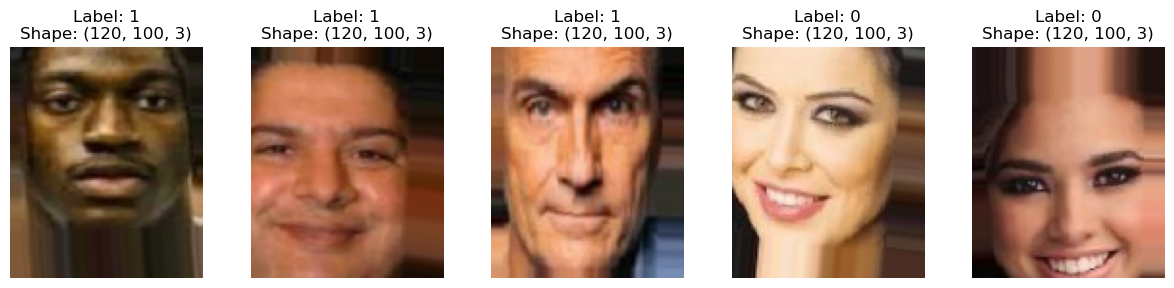

In [ ]:
def display_sample_images_with_info_after_preprocessing(generator, num_images=5):
    images, labels = next(generator)

    selected_indices = np.random.choice(images.shape[0], num_images, replace=False)

    plt.figure(figsize=(15, 3))
    for i, index in enumerate(selected_indices):
        img = images[index]
        label = labels[index]
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(f'Label: {np.argmax(label)}\nShape: {img.shape}')
        plt.axis('off')

    plt.show()

display_sample_images_with_info_after_preprocessing(train_generator)

# **Model Construction**

    Model 1

In [3]:
def depthwise_separable_resnet_block(input_tensor, filters, kernel_size=3, stride=1,conv_shortcut=False):
    
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding="same")(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.DepthwiseConv2D(kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    if conv_shortcut or stride != 1 or input_tensor.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding="same")(input_tensor)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = input_tensor

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)

    return x

def squeeze_excitation_block(input_tensor, ratio=16):
    channel_axis = -1
    filters = input_tensor.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape(se_shape)(se)
    se = layers.Dense(filters // ratio, activation='relu', kernel_regularizer=l2(0.01), use_bias=False)(se)
    se = layers.Dense(filters, activation='sigmoid', kernel_regularizer=l2(0.01), use_bias=False)(se)

    x = layers.multiply([input_tensor, se])
    return x


def inception_with_SE_block(input_tensor, filters, l2_rate):

    conv1x1 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(l2_rate))(input_tensor)

    conv3x3 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(l2_rate))(input_tensor)

    conv5x5_1 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(l2_rate))(input_tensor)
    conv5x5_2 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(l2_rate))(conv5x5_1)
    conv5x5_3 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(l2_rate))(conv5x5_2)

    pool = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_tensor)
    pool_conv = layers.Conv2D(filters, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(l2_rate))(pool)

    outputs = layers.concatenate([conv1x1, conv3x3, conv5x5_3, pool_conv], axis=-1)
    output_with_se = squeeze_excitation_block(outputs)
    return output_with_se


    Model 2

    Spatial Attention and Effect

In [4]:
def spatial_attention_block(input_tensor):
    avg_pool = layers.GlobalAveragePooling2D()(input_tensor)
    max_pool = layers.GlobalMaxPooling2D()(input_tensor)
    
    avg_pool = layers.Reshape((1, 1, input_tensor.shape[-1]))(avg_pool)
    max_pool = layers.Reshape((1, 1, input_tensor.shape[-1]))(max_pool)
    
    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    attention = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)

    output_tensor = layers.Multiply()([input_tensor, attention])
    return output_tensor


        Attention visualization and position_number tests are in the file of 'attention_visualization_position_and_number_test'

    Ensemble model

In [5]:
def Franklin_ensemble_model_1(input_shape, num_classes, l2_rate):
    inputs = layers.Input(shape=input_shape)

    x = depthwise_separable_resnet_block(inputs, filters=64)
    x = depthwise_separable_resnet_block(x, filters=32)


    x = layers.Conv2D(32, (5, 5), strides=2, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)
    x = spatial_attention_block(x) 

    x = inception_with_SE_block(x, 32, l2_rate)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x) 
    x = spatial_attention_block(x) 
    
    x = inception_with_SE_block(x, 32, l2_rate) 
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    Franklin_ensemble_model_1 = models.Model(inputs=inputs, outputs=outputs)
    return Franklin_ensemble_model_1

# **Model Training**

    Visualization of Loss, Accuracy, ROC-AUC curve, Precision, PRC, F1-score, Recall, Sensitivity, Specificity, Confusion Matrix.

In [6]:
def plot_training_history(history):
    acc = history.history['custom_accuracy']
    val_acc = history.history['val_custom_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    precision = history.history['precision']
    val_precision = history.history['val_precision']
    recall = history.history['recall']
    val_recall = history.history['val_recall']

    epochs = range(len(acc))


    plt.figure(figsize=(12, 12))

    plt.subplot(3, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(3, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(3, 2, 3)
    plt.plot(epochs, precision, label='Training Precision')
    plt.plot(epochs, val_precision, label='Validation Precision')
    plt.title('Training and Validation Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()

    plt.subplot(3, 2, 4)
    plt.plot(epochs, recall, label='Training Recall')
    plt.plot(epochs, val_recall, label='Validation Recall')
    plt.title('Training and Validation Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()
    
    # plt.suptitle("Model using custom_categorical_crossentropy", fontsize=20)
    plt.tight_layout()
    plt.show()

def load_and_predict_model(model_path, test_generator, custom_objects):
    loaded_model = load_model(model_path, custom_objects=custom_objects)
    all_images = []
    all_true_labels = []

    for _ in range(test_generator.samples // test_generator.batch_size):
        images, true_labels = next(test_generator)
        all_images.extend(images)
        all_true_labels.extend(true_labels)

    all_images = np.array(all_images)
    all_true_labels = np.argmax(np.array(all_true_labels), axis=1)

    predictions = loaded_model.predict(all_images)
    predicted_labels = np.argmax(predictions, axis=1)

    return all_true_labels, predicted_labels, predictions

def calculate_f1_scores(true_labels, predicted_probabilities):
    thresholds = np.linspace(0, 1, 100)
    f1_scores = []

    for thresh in thresholds:
        predicted_labels_thresh = (predicted_probabilities[:, 1] >= thresh).astype(int)

        precision = precision_score(true_labels, predicted_labels_thresh, zero_division=0)
        recall = recall_score(true_labels, predicted_labels_thresh)

        if precision + recall == 0:
            f1_scores.append(0)
        else:
            f1 = 2 * (precision * recall) / (precision + recall)
            f1_scores.append(f1)

    return thresholds, f1_scores

def calculate_sensitivity_specificity(true_labels, predicted_probabilities):
    thresholds = np.linspace(0, 1, 100)
    sensitivity_scores = []
    specificity_scores = []

    for thresh in thresholds:
        predicted_labels_thresh = (predicted_probabilities[:, 1] >= thresh).astype(int)

        tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels_thresh).ravel()

        sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

        sensitivity_scores.append(sensitivity)
        specificity_scores.append(specificity)

    return thresholds, sensitivity_scores, specificity_scores


def plot_confusion_matrix(true_labels, predicted_labels):
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


def plot_roc_auc_curve(true_labels, predicted_probabilities):
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities[:, 1]) 
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (Area Under the Curve = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(true_labels, predicted_probabilities):
    precision, recall, _ = precision_recall_curve(true_labels, predicted_probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

def plot_precision(true_labels, predicted_probabilities):
    precision, recall, thresholds = precision_recall_curve(true_labels, predicted_probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

def plot_recall(true_labels, predicted_probabilities):
    precision, recall, thresholds = precision_recall_curve(true_labels, predicted_probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, recall[:-1], marker='.')
    plt.title('Recall as a function of the decision threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Recall')
    plt.show()
    
def plot_f1_scores(thresholds, f1_scores):
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, f1_scores, marker='.')
    plt.title('F1-Score as a function of the decision threshold')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.show()

def plot_sensitivity(thresholds, sensitivity_scores):
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, sensitivity_scores, marker='.')
    plt.title('Sensitivity as a function of the decision threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Sensitivity')
    plt.show()

def plot_specificity(thresholds, specificity_scores):
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, specificity_scores, marker='.')
    plt.title('Specificity as a function of the decision threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Specificity')
    plt.show()

def print_classification_metrics(true_labels, predicted_labels, predicted_probabilities):
    cm = confusion_matrix(true_labels, predicted_labels)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    auc = roc_auc_score(true_labels, predicted_probabilities[:, 1]) if predicted_probabilities is not None else "N/A"

    print("Classification Report:")
    print(classification_report(true_labels, predicted_labels))
    print(f"Sensitivity: {sensitivity:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"AUC: {auc}")
    print("Confusion Matrix:")
    print(cm)
    


    Customize loss and Accuracy

In [7]:
def custom_categorical_crossentropy(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1. - tf.keras.backend.epsilon())
    loss = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
    return loss

def custom_accuracy(y_true, y_pred):
    predicted_classes = tf.argmax(y_pred, axis=1)
    true_classes = tf.argmax(y_true, axis=1)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted_classes, true_classes), tf.float32))
    return accuracy

    Training model using custom custom_categorical_crossentropy and custom_accuracy

        Training model 1

In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=12, verbose=1, mode='min')
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min')

Franklin_ensemble_model_1 = Franklin_ensemble_model_1((120, 100, 3), num_classes=2, l2_rate=0.001)
Franklin_ensemble_model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                       loss=custom_categorical_crossentropy,
                       metrics=[custom_accuracy, Precision(name='precision'), Recall(name='recall')]
)
Franklin_ensemble_model_1.summary()
print(Franklin_ensemble_model_1.optimizer) 
print(Franklin_ensemble_model_1.loss)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 120, 100, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 120, 100, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [9]:
history1 = Franklin_ensemble_model_1.fit(train_generator, epochs=50, validation_data=validation_generator,callbacks=[early_stopping, lr_reduction])

Epoch 1/50
127/127 [==============================] - 17s 117ms/step - loss: 1.0757 - custom_accuracy: 0.6585 - precision: 0.6578 - recall: 0.6578 - val_loss: 1.3054 - val_custom_accuracy: 0.4984 - val_precision: 0.5000 - val_recall: 0.5000 - lr: 0.0010
Epoch 2/50
127/127 [==============================] - 13s 100ms/step - loss: 0.5500 - custom_accuracy: 0.7874 - precision: 0.7858 - recall: 0.7858 - val_loss: 1.2421 - val_custom_accuracy: 0.5003 - val_precision: 0.5000 - val_recall: 0.5000 - lr: 0.0010
Epoch 3/50
127/127 [==============================] - 13s 101ms/step - loss: 0.3941 - custom_accuracy: 0.8537 - precision: 0.8526 - recall: 0.8526 - val_loss: 1.0572 - val_custom_accuracy: 0.5055 - val_precision: 0.5050 - val_recall: 0.5050 - lr: 0.0010
Epoch 4/50
127/127 [==============================] - 13s 100ms/step - loss: 0.3434 - custom_accuracy: 0.8627 - precision: 0.8654 - recall: 0.8654 - val_loss: 0.3804 - val_custom_accuracy: 0.8630 - val_precision: 0.8621 - val_recall: 0.86

In [10]:
model_path1 = 'modelsave/Franklin_ensemble_model_1.h5'
Franklin_ensemble_model_1.save(model_path1)


        Train model 2

# **Model Testing and Evaluation**

    Evaluate and Visualize Loss, Accuracy, ROC-AUC, Precision, PRC, F1-score, Recall, Sensitivity, Specificity, Confusion Matrix.

        Model 1 testing and evaluation

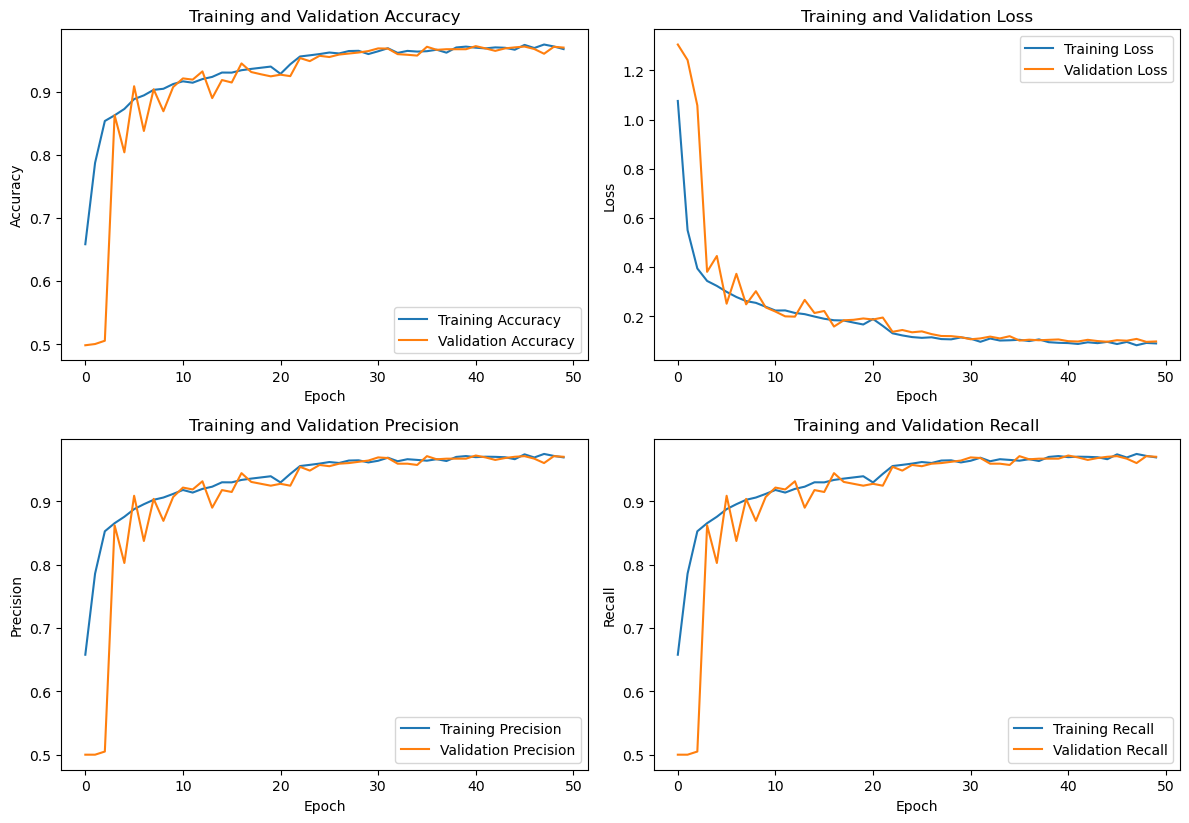

In [11]:
model_path = model_path1
custom_objects={'custom_categorical_crossentropy': custom_categorical_crossentropy,'custom_accuracy': custom_accuracy}

plot_training_history(history1)

30/30 [==============================] - 0s 7ms/step


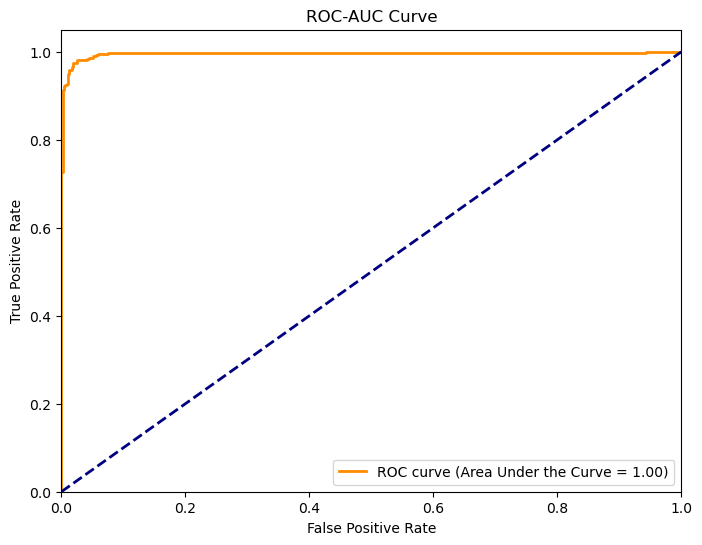

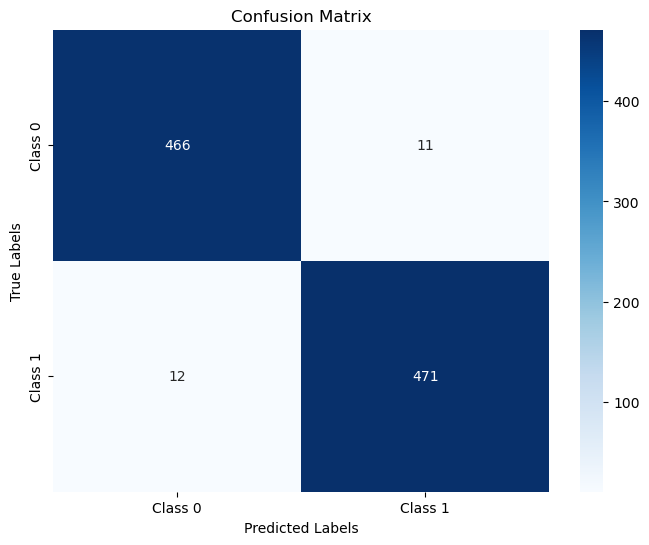

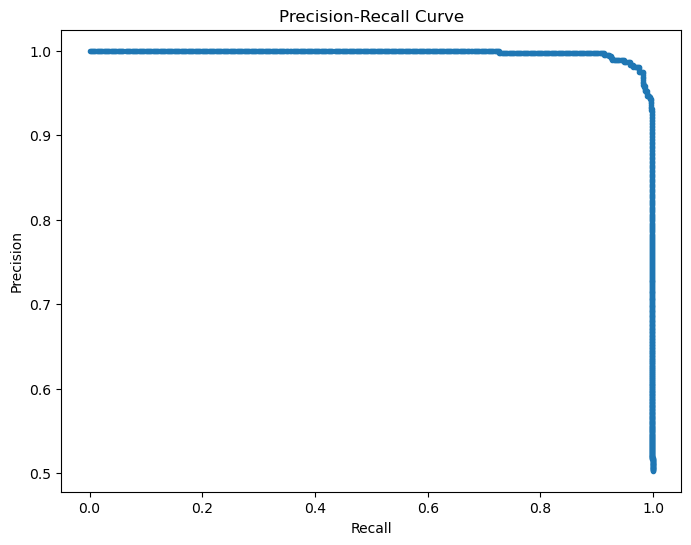

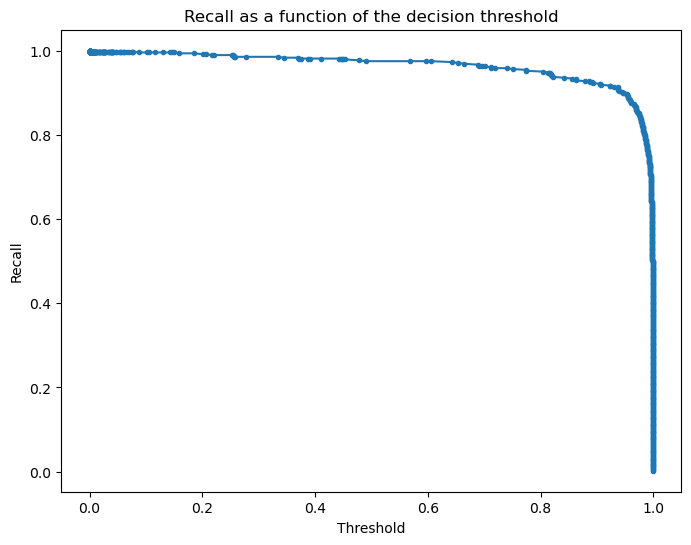

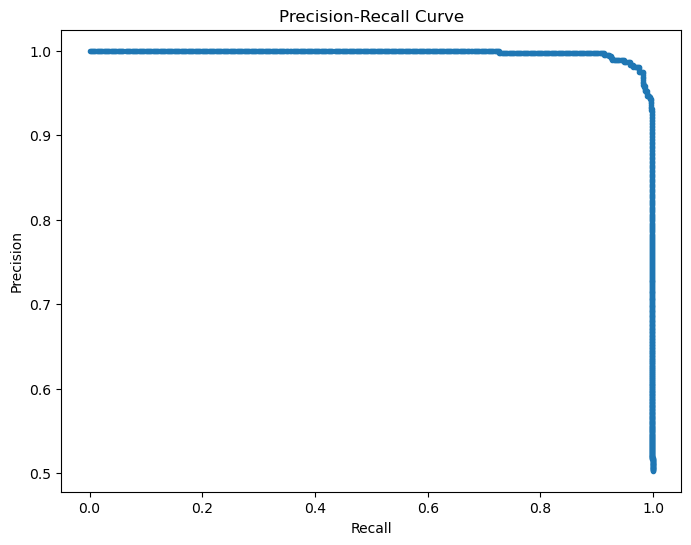

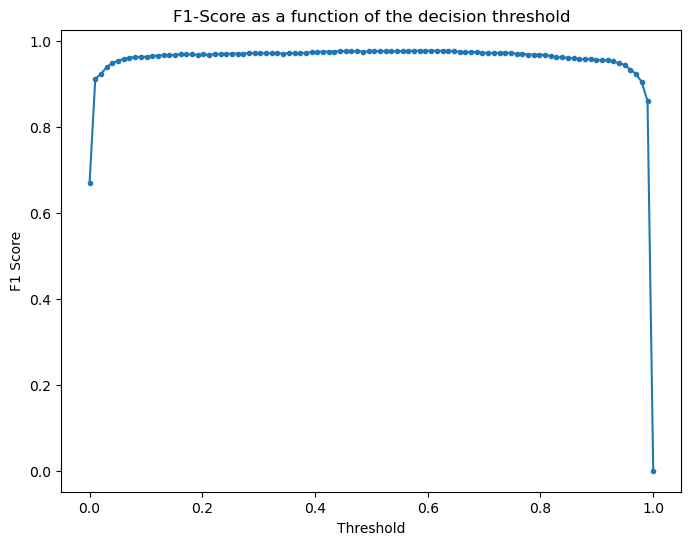

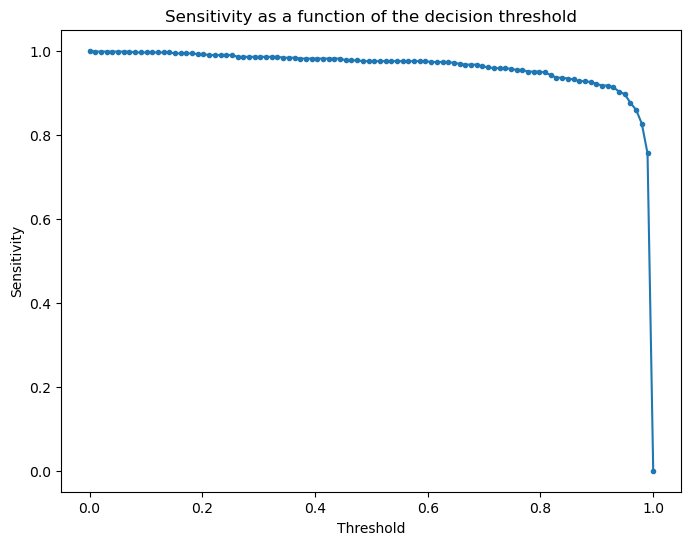

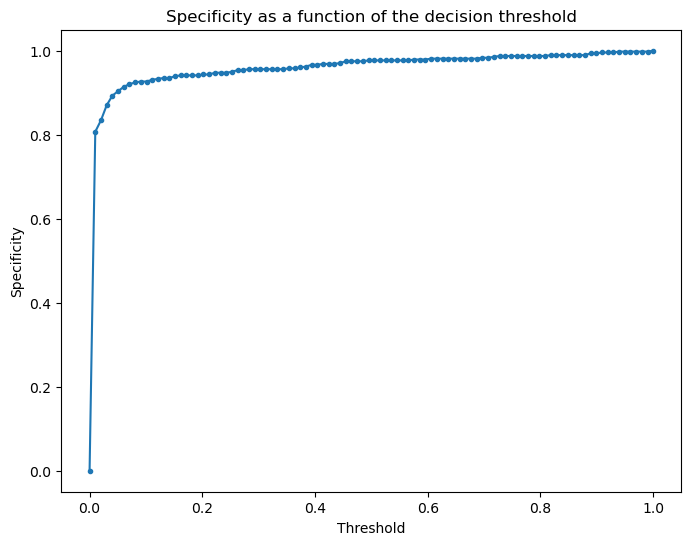

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       477
           1       0.98      0.98      0.98       483

    accuracy                           0.98       960
   macro avg       0.98      0.98      0.98       960
weighted avg       0.98      0.98      0.98       960

Sensitivity: 0.98
Specificity: 0.98
Precision: 0.98
Recall: 0.98
F1 Score: 0.98
AUC: 0.9958678941451706
Confusion Matrix:
[[466  11]
 [ 12 471]]
7/7 [==============================] - 0s 26ms/step - loss: 0.0516 - custom_accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799


In [12]:
true_labels, predicted_labels, predicted_probabilities = load_and_predict_model(model_path, test_generator, custom_objects)

plot_roc_auc_curve(true_labels, predicted_probabilities)
plot_confusion_matrix(true_labels, predicted_labels)
plot_precision(true_labels, predicted_probabilities)
plot_recall(true_labels, predicted_probabilities)
plot_precision_recall_curve(true_labels, predicted_probabilities)

thresholds, f1_scores = calculate_f1_scores(true_labels, predicted_probabilities)
plot_f1_scores(thresholds, f1_scores)

thresholds, sensitivity_scores, specificity_scores = calculate_sensitivity_specificity(true_labels, predicted_probabilities)
plot_sensitivity(thresholds, sensitivity_scores)
plot_specificity(thresholds, specificity_scores)

print_classification_metrics(true_labels, predicted_labels, predicted_probabilities)


evaluation_result = Franklin_ensemble_model_1.evaluate(test_generator, steps=7)



1/1 [==============================] - 0s 210ms/step


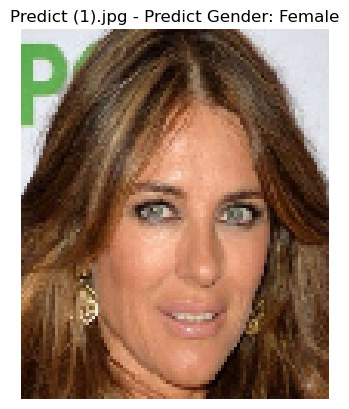

1/1 [==============================] - 0s 12ms/step


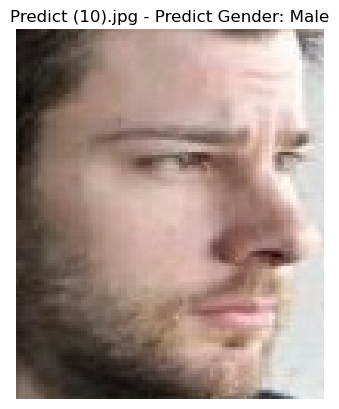

1/1 [==============================] - 0s 12ms/step


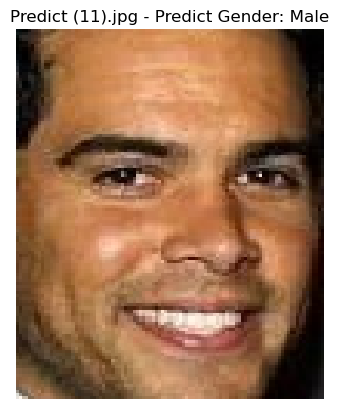

1/1 [==============================] - 0s 12ms/step


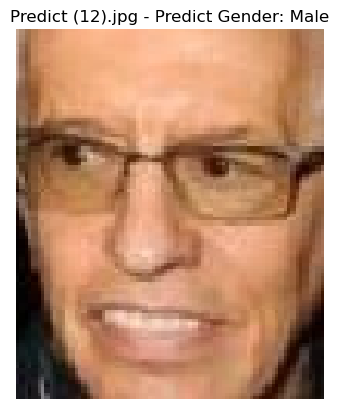

1/1 [==============================] - 0s 12ms/step


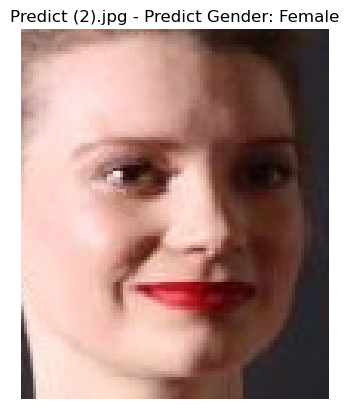

1/1 [==============================] - 0s 12ms/step


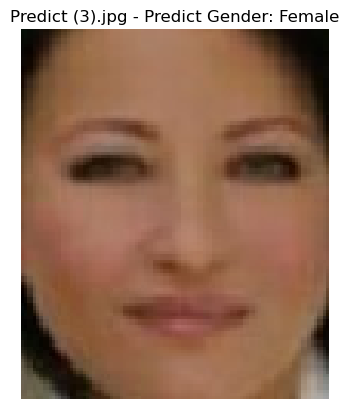

1/1 [==============================] - 0s 13ms/step


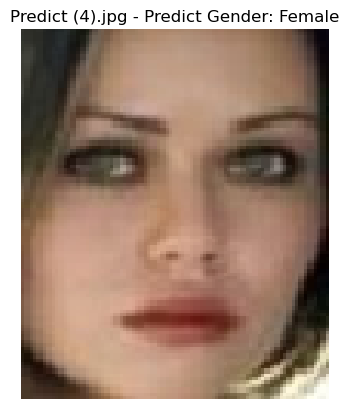

1/1 [==============================] - 0s 11ms/step


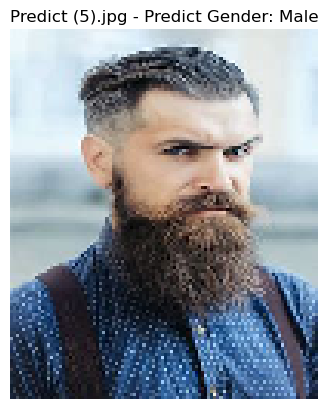

1/1 [==============================] - 0s 13ms/step


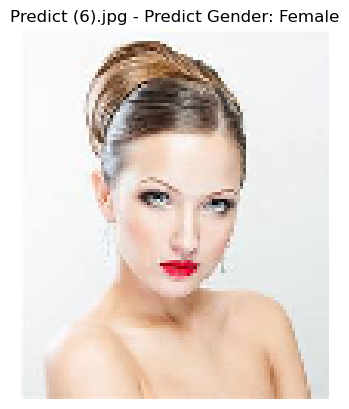

1/1 [==============================] - 0s 12ms/step


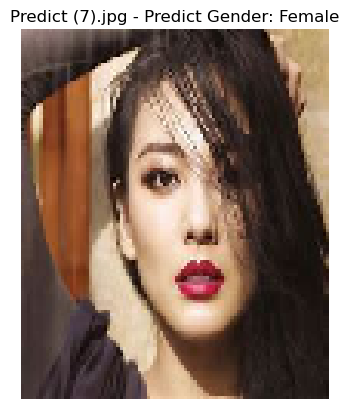

1/1 [==============================] - 0s 11ms/step


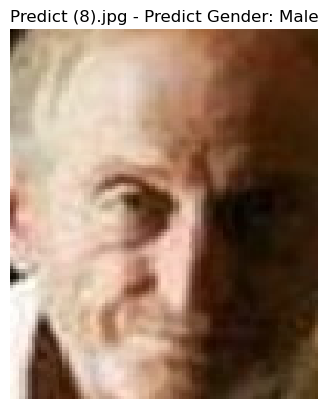

1/1 [==============================] - 0s 11ms/step


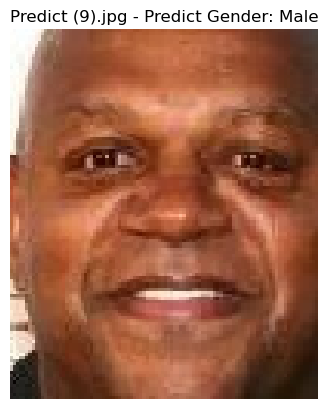

In [12]:
model = load_model(model_path1, custom_objects={'custom_categorical_crossentropy': custom_categorical_crossentropy, 'custom_accuracy': custom_accuracy})
folder_path = 'Image_Datasets/images to predict'  

for img_file in os.listdir(folder_path):
    if img_file.endswith(".jpg") or img_file.endswith(".png"):  
        img_path = os.path.join(folder_path, img_file)
        img = image.load_img(img_path, target_size=(120, 100))  
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  
        img_array /= 255.0  

        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions, axis=1)
        prediction_text = "Female" if predicted_class[0] == 0 else "Male"

        plt.imshow(img)
        plt.title(f"{img_file} - Predict Gender: {prediction_text}")
        plt.axis('off')  
        plt.show()

        Model 2 testing and evaluation

    Compare model evaluation using in-build loss and accuracy

In [7]:
def plot_training_history_2(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))


    plt.figure(figsize=(12, 12))

    # Accuracy
    plt.subplot(3, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(3, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

        Training model 1 using in-build loss and accuracy

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=12, verbose=1, mode='min')
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min')

Franklin_ensemble_model_1_in_build = Franklin_ensemble_model_1((120, 100, 3), num_classes=2, l2_rate=0.001)
Franklin_ensemble_model_1_in_build.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy']
)
Franklin_ensemble_model_1_in_build.summary()
print(Franklin_ensemble_model_1_in_build.optimizer) 
print(Franklin_ensemble_model_1_in_build.loss)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 120, 100, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 120, 100, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
history1_2 = Franklin_ensemble_model_1_in_build.fit(train_generator, epochs=50, validation_data=validation_generator,callbacks=[early_stopping, lr_reduction])

Epoch 1/50
126/126 [==============================] - 15s 102ms/step - loss: 1.1436 - accuracy: 0.5320 - val_loss: 0.8697 - val_accuracy: 0.4995 - lr: 0.0010
Epoch 2/50
126/126 [==============================] - 12s 98ms/step - loss: 0.5682 - accuracy: 0.7672 - val_loss: 1.2671 - val_accuracy: 0.4995 - lr: 0.0010
Epoch 3/50
126/126 [==============================] - 13s 99ms/step - loss: 0.4208 - accuracy: 0.8181 - val_loss: 1.7726 - val_accuracy: 0.4995 - lr: 0.0010
Epoch 4/50
126/126 [==============================] - 13s 100ms/step - loss: 0.3709 - accuracy: 0.8431 - val_loss: 0.7196 - val_accuracy: 0.5305 - lr: 0.0010
Epoch 5/50
126/126 [==============================] - 13s 100ms/step - loss: 0.3523 - accuracy: 0.8544 - val_loss: 0.3392 - val_accuracy: 0.8571 - lr: 0.0010
Epoch 6/50
126/126 [==============================] - 13s 100ms/step - loss: 0.3171 - accuracy: 0.8703 - val_loss: 0.2774 - val_accuracy: 0.8911 - lr: 0.0010
Epoch 7/50
126/126 [==============================] - 

In [ ]:
model_path1_2 = 'modelsave/Franklin_ensemble_model_1_in_build.h5'
Franklin_ensemble_model_1_in_build.save(model_path1_2)

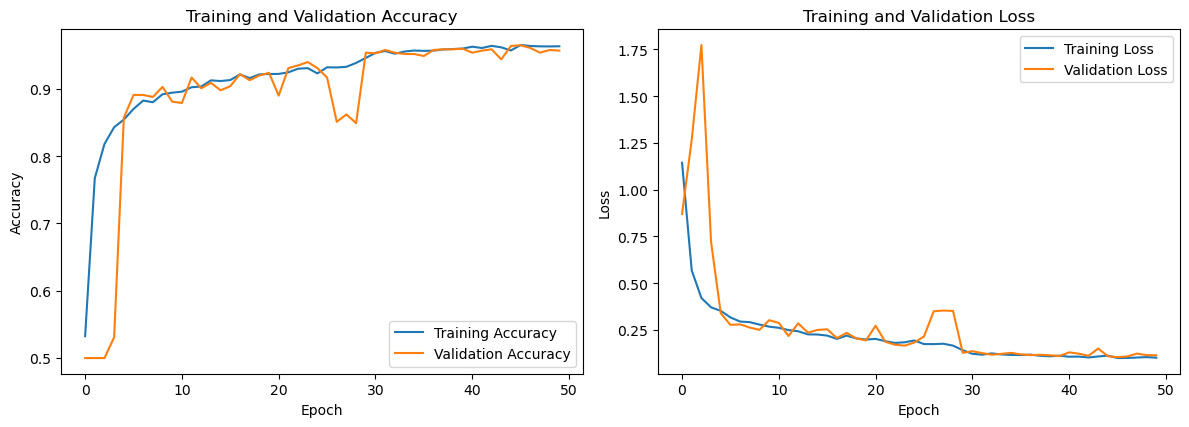

7/7 [==============================] - 0s 26ms/step - loss: 0.1033 - accuracy: 0.9598
Loss: 0.10327800363302231
Accuracy: 0.9598214030265808


In [ ]:
plot_training_history_2(history1_2)
evaluation_result = Franklin_ensemble_model_1_in_build.evaluate(test_generator, steps=7)
print(f"Loss: {evaluation_result[0]}")
print(f"Accuracy: {evaluation_result[1]}")

        Training model 2 using in-build loss and accuracy

    Compare model with not using attention mechanism

        Model 1 not using attention

In [ ]:
def Franklin_ensemble_model_1_no_attention(input_shape, num_classes, l2_rate):
    inputs = layers.Input(shape=input_shape)

    x = depthwise_separable_resnet_block(inputs, filters=64)
    x = depthwise_separable_resnet_block(x, filters=32)

    x = layers.Conv2D(32, (5, 5), strides=2, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    x = inception_with_SE_block(x, 32, l2_rate)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x) 
      
    x = inception_with_SE_block(x, 32, l2_rate) 
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    combined_model_with_attention = models.Model(inputs=inputs, outputs=outputs)
    return combined_model_with_attention

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=12, verbose=1, mode='min')
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min')

Franklin_ensemble_model_1_no_attention = Franklin_ensemble_model_1_no_attention((120, 100, 3), num_classes=2, l2_rate=0.001)
Franklin_ensemble_model_1_no_attention.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy']
)
Franklin_ensemble_model_1_no_attention.summary()
print(Franklin_ensemble_model_1_no_attention.optimizer) 
print(Franklin_ensemble_model_1_no_attention.loss)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 120, 100, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 120, 100, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
history1_3 = Franklin_ensemble_model_1_no_attention.fit(train_generator, epochs=50, validation_data=validation_generator,callbacks=[early_stopping, lr_reduction])

Epoch 1/50
126/126 [==============================] - 14s 101ms/step - loss: 1.1970 - accuracy: 0.5950 - val_loss: 0.9289 - val_accuracy: 0.4995 - lr: 0.0010
Epoch 2/50
126/126 [==============================] - 13s 99ms/step - loss: 0.7055 - accuracy: 0.6964 - val_loss: 0.7805 - val_accuracy: 0.4995 - lr: 0.0010
Epoch 3/50
126/126 [==============================] - 12s 98ms/step - loss: 0.5373 - accuracy: 0.7725 - val_loss: 0.7782 - val_accuracy: 0.5085 - lr: 0.0010
Epoch 4/50
126/126 [==============================] - 13s 99ms/step - loss: 0.4315 - accuracy: 0.8358 - val_loss: 0.6179 - val_accuracy: 0.6503 - lr: 0.0010
Epoch 5/50
126/126 [==============================] - 13s 99ms/step - loss: 0.3742 - accuracy: 0.8620 - val_loss: 0.4221 - val_accuracy: 0.8272 - lr: 0.0010
Epoch 6/50
126/126 [==============================] - 13s 100ms/step - loss: 0.3338 - accuracy: 0.8768 - val_loss: 1.0514 - val_accuracy: 0.5674 - lr: 0.0010
Epoch 7/50
126/126 [==============================] - 13

In [ ]:
model_path1_3 = 'modelsave/Franklin_ensemble_model_1_no_attention.h5'
Franklin_ensemble_model_1_no_attention.save(model_path1_3)

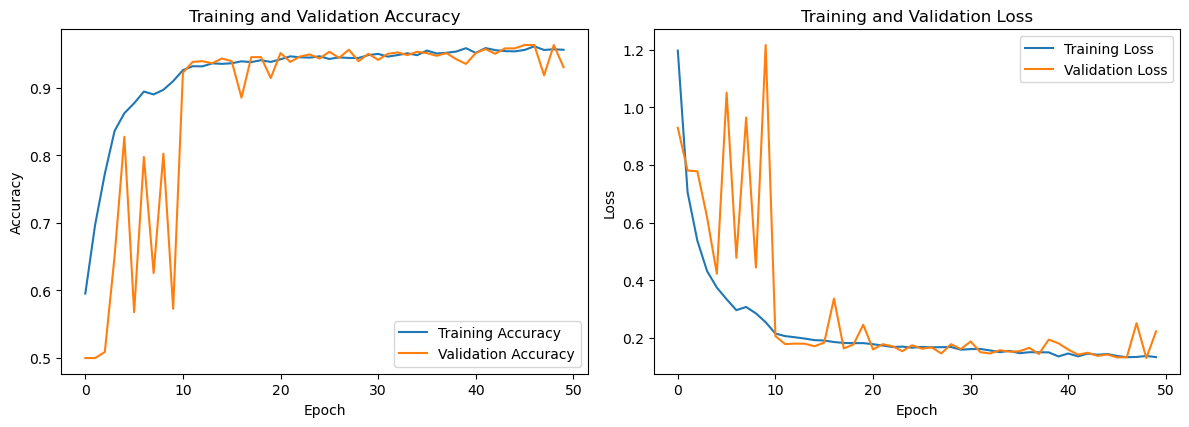

7/7 [==============================] - 0s 28ms/step - loss: 0.2310 - accuracy: 0.9196
Loss: 0.23097001016139984
Accuracy: 0.9196428656578064


In [ ]:
plot_training_history_2(history1_3)
evaluation_result = Franklin_ensemble_model_1_no_attention.evaluate(test_generator, steps=7)
print(f"Loss: {evaluation_result[0]}")
print(f"Accuracy: {evaluation_result[1]}")

        Model 2 not using attention

    Hyparameter TEST (file name: compare_model_with_pre_train_model)

    Compare model_1 and model_2 with Pre-train models (ResNet101, InceptionV3, and MobileNetV2)
    (file name: hyperparameter_tuning_test)

# **Bonus Point**

In [8]:
def weighted_cumulative_crossentropy(y_true, y_pred, weight_factor=0.5):
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())

    basic_crossentropy = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)

    cumulative_y_pred = tf.cumsum(y_pred, axis=-1)
    cumulative_y_true = tf.cumsum(y_true, axis=-1)
    cumulative_loss = tf.reduce_sum(tf.abs(cumulative_y_pred - cumulative_y_true), axis=-1)

    combined_loss = (1 - weight_factor) * basic_crossentropy + weight_factor * cumulative_loss
    return combined_loss

    Training model using custom weighted_cumulative_crossentropy loss function.

        Model 1 using using custom weighted_cumulative_crossentropy loss function.

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=12, verbose=1, mode='min')
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min')

Franklin_ensemble_model_1_using_new_loss = Franklin_ensemble_model_1((120, 100, 3), num_classes=2, l2_rate=0.001)
Franklin_ensemble_model_1_using_new_loss.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                       loss=weighted_cumulative_crossentropy,
                       metrics=[custom_accuracy, Precision(name='precision'), Recall(name='recall')]
)
Franklin_ensemble_model_1_using_new_loss.summary()
print(Franklin_ensemble_model_1_using_new_loss.optimizer) 
print(Franklin_ensemble_model_1_using_new_loss.loss)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 120, 100, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 120, 100, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [10]:
history1_4 = Franklin_ensemble_model_1_using_new_loss.fit(train_generator, epochs=50, validation_data=validation_generator,callbacks=[early_stopping, lr_reduction])


Epoch 1/50
127/127 [==============================] - 15s 103ms/step - loss: 1.0365 - custom_accuracy: 0.5629 - precision: 0.5652 - recall: 0.5652 - val_loss: 0.7800 - val_custom_accuracy: 0.5007 - val_precision: 0.5000 - val_recall: 0.5000 - lr: 0.0010
Epoch 2/50
127/127 [==============================] - 13s 98ms/step - loss: 0.5216 - custom_accuracy: 0.7218 - precision: 0.7253 - recall: 0.7253 - val_loss: 0.9273 - val_custom_accuracy: 0.4997 - val_precision: 0.5000 - val_recall: 0.5000 - lr: 0.0010
Epoch 3/50
127/127 [==============================] - 13s 99ms/step - loss: 0.3460 - custom_accuracy: 0.8227 - precision: 0.8214 - recall: 0.8214 - val_loss: 0.7681 - val_custom_accuracy: 0.5088 - val_precision: 0.5099 - val_recall: 0.5099 - lr: 0.0010
Epoch 4/50
127/127 [==============================] - 13s 99ms/step - loss: 0.2816 - custom_accuracy: 0.8627 - precision: 0.8617 - recall: 0.8617 - val_loss: 0.3684 - val_custom_accuracy: 0.8021 - val_precision: 0.8036 - val_recall: 0.8036 

In [11]:
model_path1_4 = 'modelsave/Franklin_ensemble_model_1_using_new_loss.h5'
Franklin_ensemble_model_1_using_new_loss.save(model_path1_4)

30/30 [==============================] - 0s 10ms/step


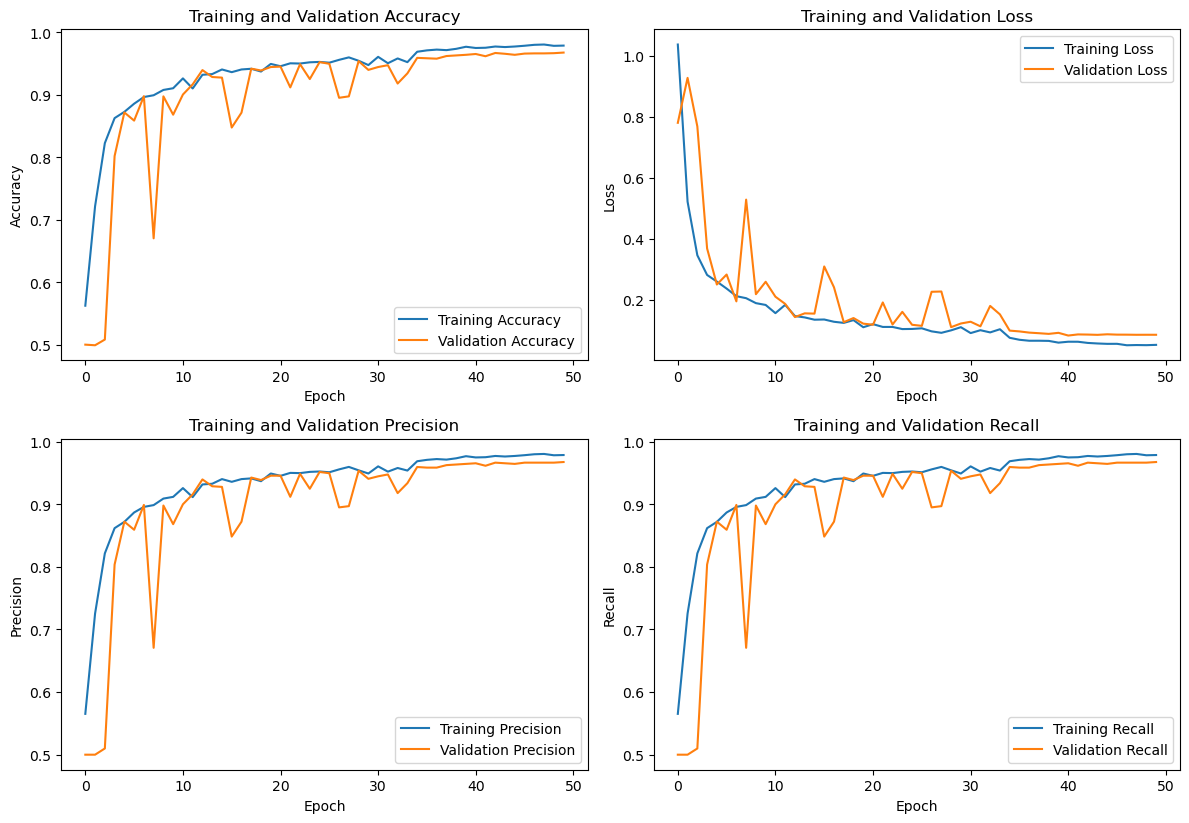

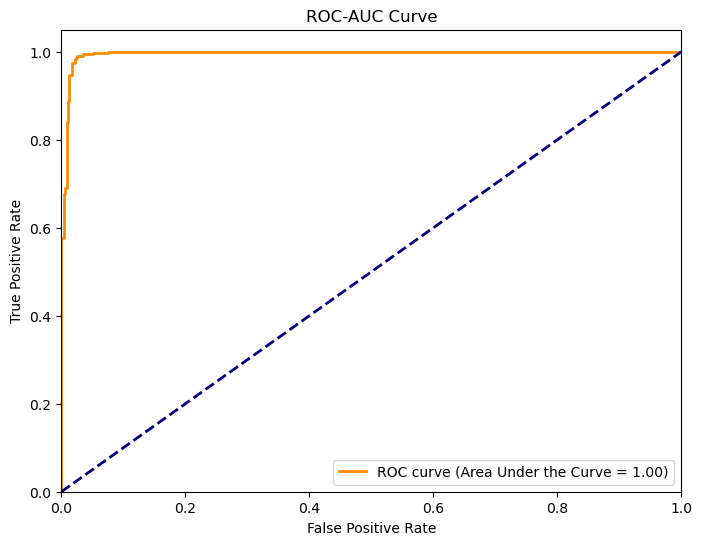

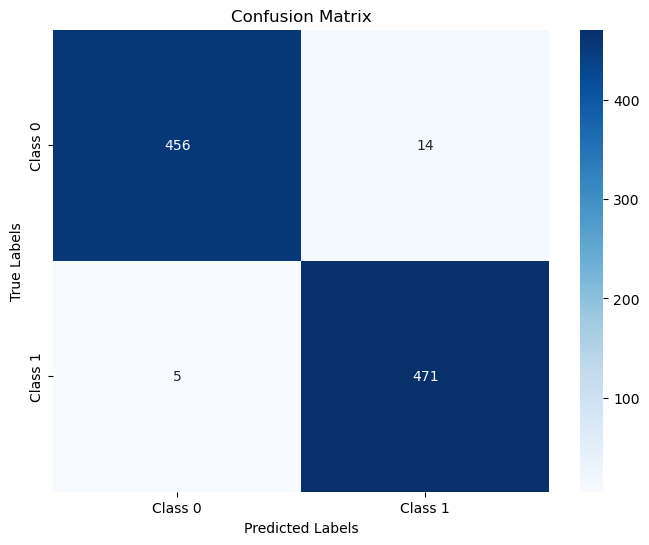

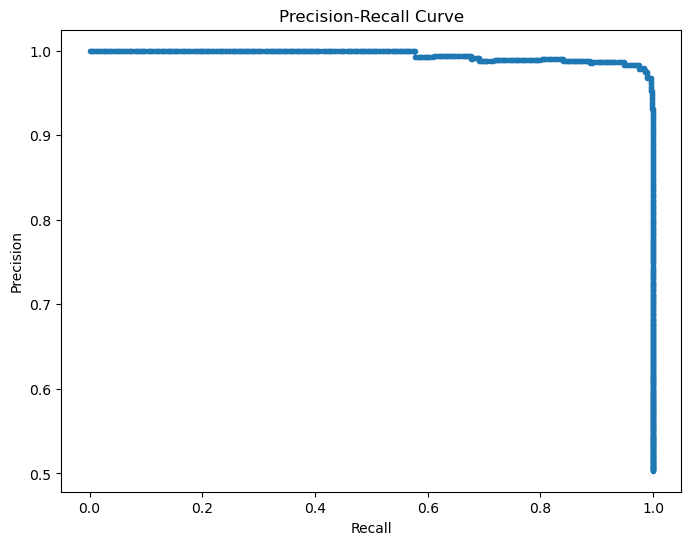

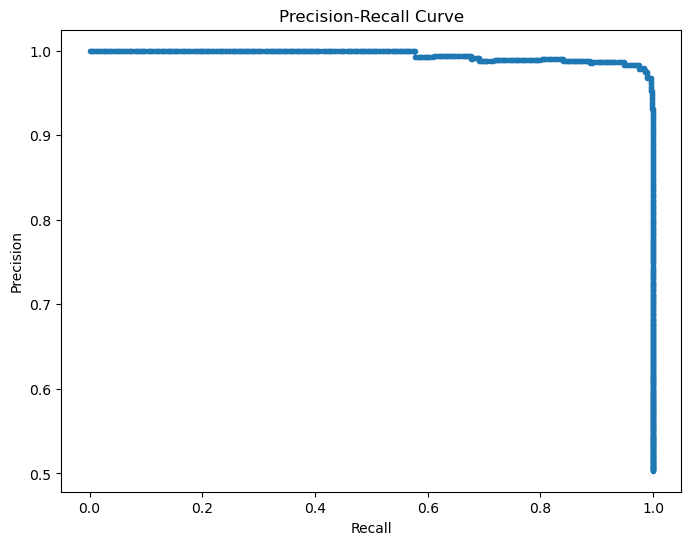

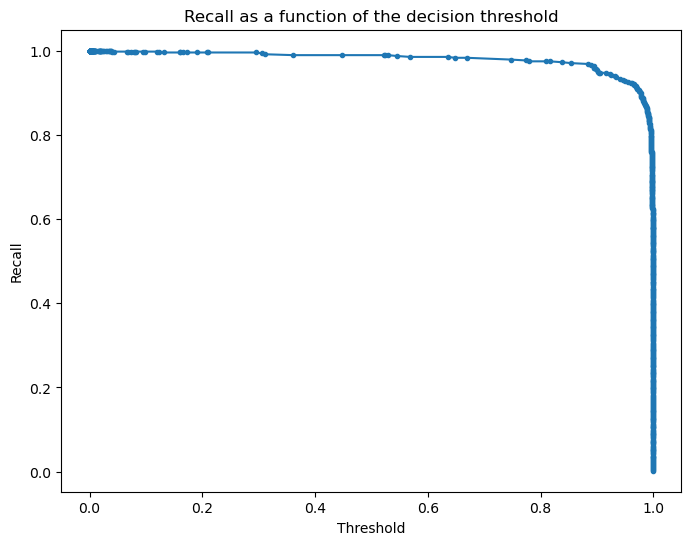

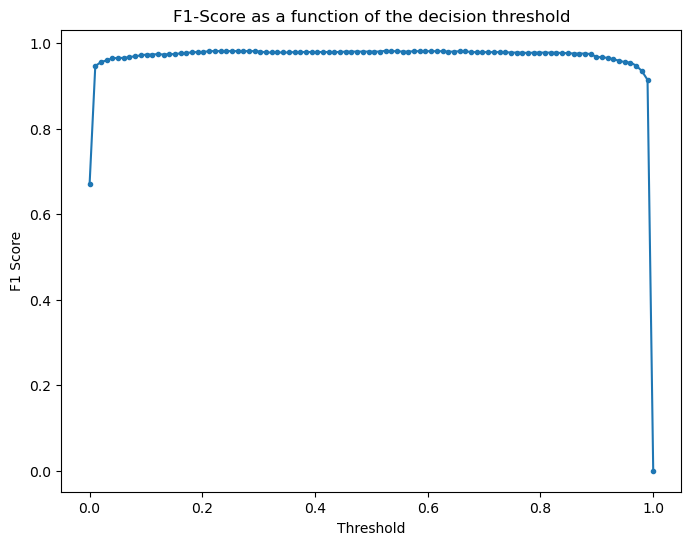

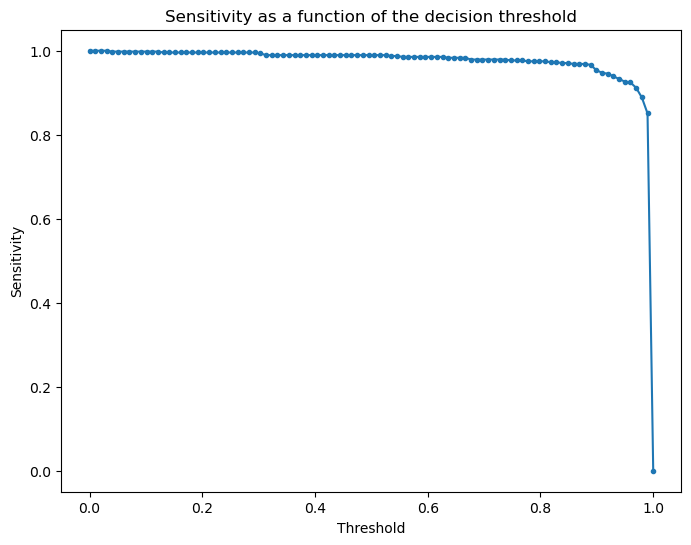

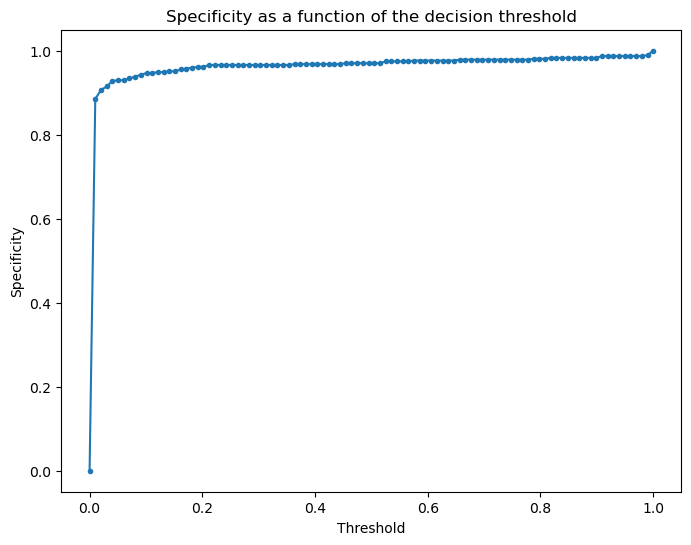

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       470
           1       0.97      0.99      0.98       476

    accuracy                           0.98       946
   macro avg       0.98      0.98      0.98       946
weighted avg       0.98      0.98      0.98       946

Sensitivity: 0.99
Specificity: 0.97
Precision: 0.97
Recall: 0.99
F1 Score: 0.98
AUC: 0.9956731628821742
Confusion Matrix:
[[456  14]
 [  5 471]]
7/7 [==============================] - 0s 26ms/step - loss: 0.0423 - custom_accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821


In [13]:
model_path = model_path1_4
custom_objects={'weighted_cumulative_crossentropy': weighted_cumulative_crossentropy,'custom_accuracy': custom_accuracy}
true_labels, predicted_labels, predicted_probabilities = load_and_predict_model(model_path, test_generator, custom_objects)


plot_training_history(history1_4)

plot_roc_auc_curve(true_labels, predicted_probabilities)
plot_confusion_matrix(true_labels, predicted_labels)
plot_precision_recall_curve(true_labels, predicted_probabilities)
plot_precision(true_labels, predicted_probabilities)
plot_recall(true_labels, predicted_probabilities)

thresholds, f1_scores = calculate_f1_scores(true_labels, predicted_probabilities)
plot_f1_scores(thresholds, f1_scores)

thresholds, sensitivity_scores, specificity_scores = calculate_sensitivity_specificity(true_labels, predicted_probabilities)
plot_sensitivity(thresholds, sensitivity_scores)
plot_specificity(thresholds, specificity_scores)

print_classification_metrics(true_labels, predicted_labels, predicted_probabilities)


evaluation_result = Franklin_ensemble_model_1_using_new_loss.evaluate(test_generator, steps=7)

        Model 2 using using custom weighted_cumulative_crossentropy loss function.

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=12, verbose=1, mode='min')
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min')

Franklin_ensemble_model_2_using_new_loss = Franklin_ensemble_model_2((120, 100, 3), num_classes=2, l2_rate=0.001)
Franklin_ensemble_model_2_using_new_loss.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                       loss=weighted_cumulative_crossentropy,
                       metrics=[custom_accuracy, Precision(name='precision'), Recall(name='recall')]
)
Franklin_ensemble_model_2_using_new_loss.summary()
print(Franklin_ensemble_model_2_using_new_loss.optimizer) 
print(Franklin_ensemble_model_2_using_new_loss.loss)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 120, 100, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 120, 100, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
history2_4 = Franklin_ensemble_model_2_using_new_loss.fit(train_generator, epochs=50, validation_data=validation_generator,callbacks=[early_stopping, lr_reduction])


Epoch 1/50
126/126 [==============================] - 14s 101ms/step - loss: 0.8024 - custom_accuracy: 0.5791 - precision: 0.5776 - recall: 0.5776 - val_loss: 1.0234 - val_custom_accuracy: 0.5020 - val_precision: 0.4995 - val_recall: 0.4995 - lr: 0.0010
Epoch 2/50
126/126 [==============================] - 13s 100ms/step - loss: 0.4982 - custom_accuracy: 0.7517 - precision: 0.7517 - recall: 0.7517 - val_loss: 0.8243 - val_custom_accuracy: 0.5052 - val_precision: 0.5045 - val_recall: 0.5045 - lr: 0.0010
Epoch 3/50
126/126 [==============================] - 13s 100ms/step - loss: 0.3667 - custom_accuracy: 0.8229 - precision: 0.8233 - recall: 0.8233 - val_loss: 0.4311 - val_custom_accuracy: 0.7869 - val_precision: 0.7842 - val_recall: 0.7842 - lr: 0.0010
Epoch 4/50
126/126 [==============================] - 13s 100ms/step - loss: 0.3080 - custom_accuracy: 0.8483 - precision: 0.8481 - recall: 0.8481 - val_loss: 0.3707 - val_custom_accuracy: 0.7927 - val_precision: 0.7952 - val_recall: 0.79

In [ ]:
model_path2_4 = 'modelsave/Franklin_ensemble_model_2_using_new_loss.h5'
Franklin_ensemble_model_2_using_new_loss.save(model_path2_4)

30/30 [==============================] - 1s 12ms/step


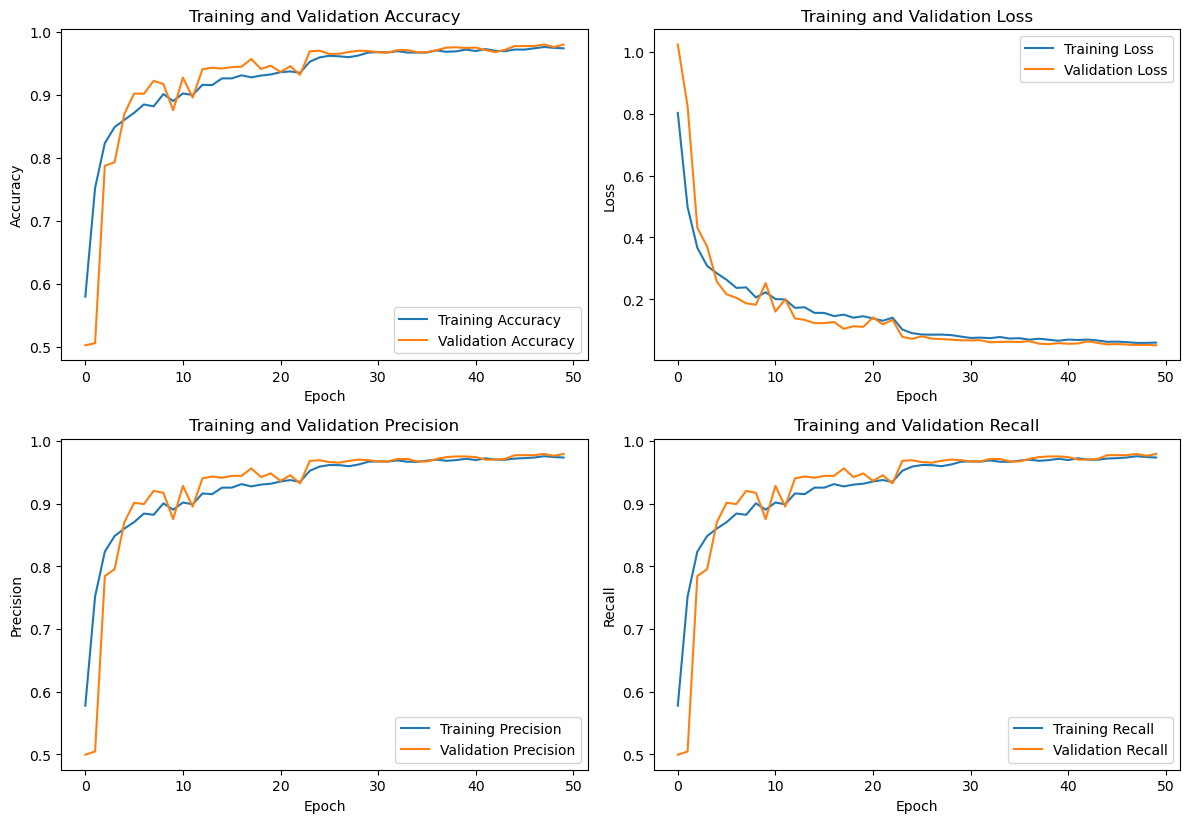

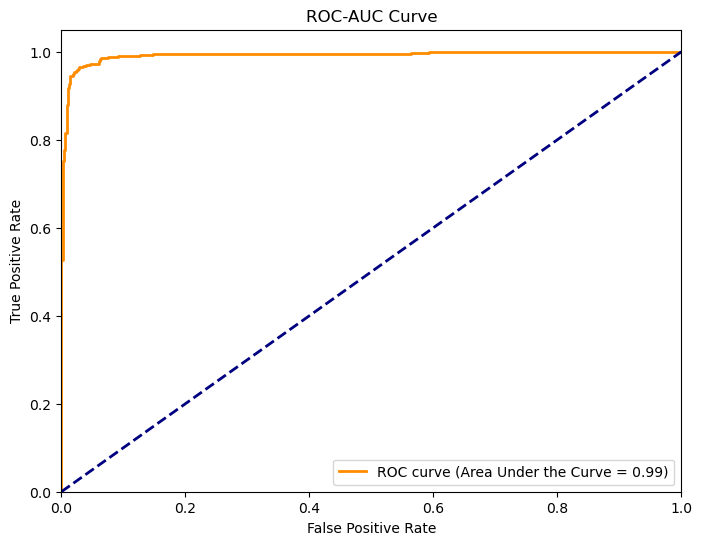

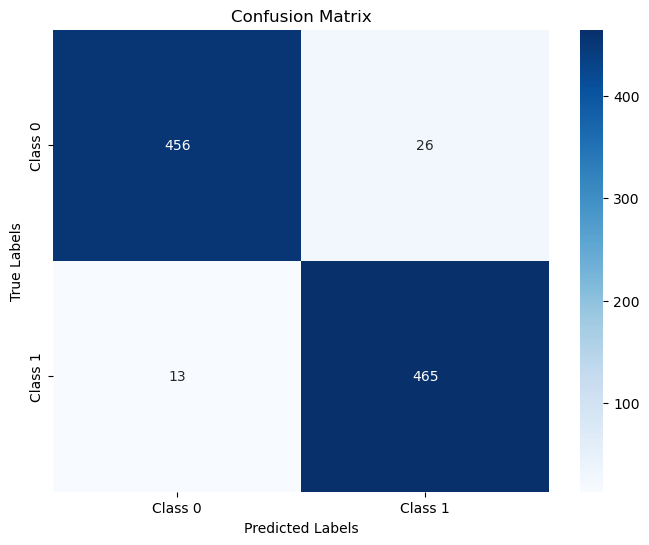

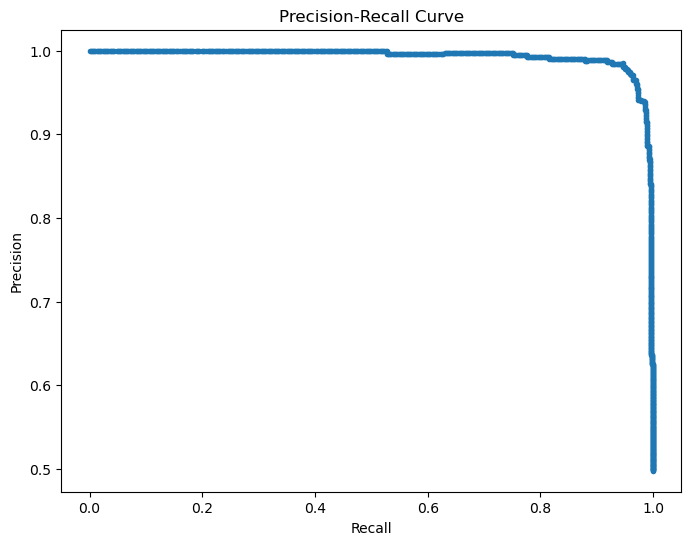

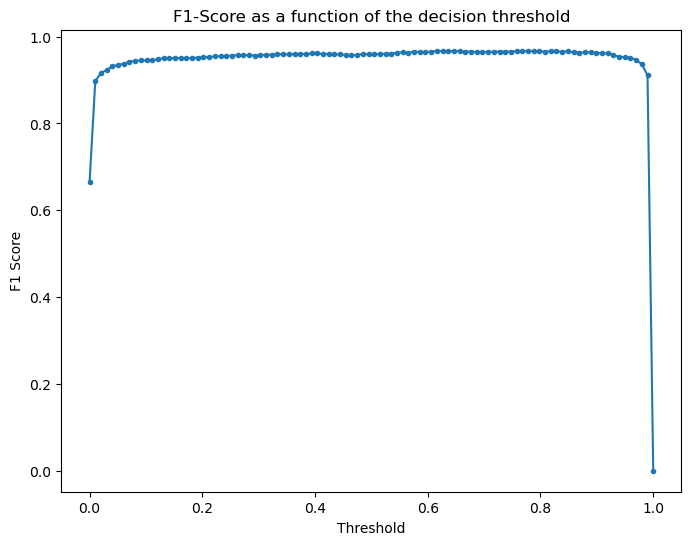

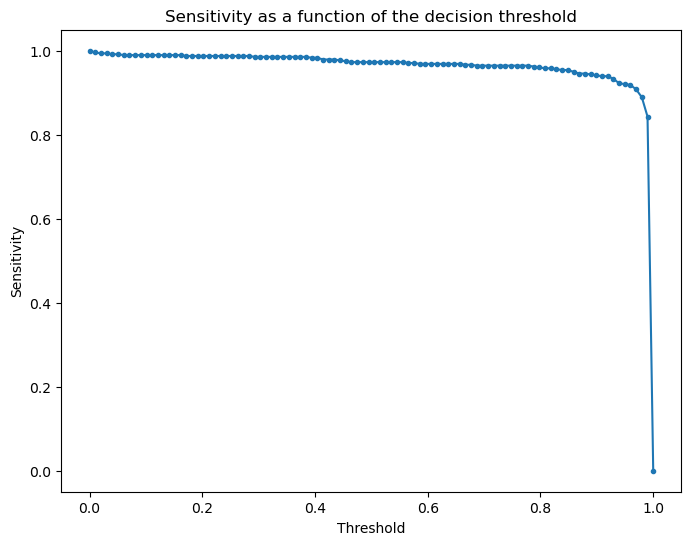

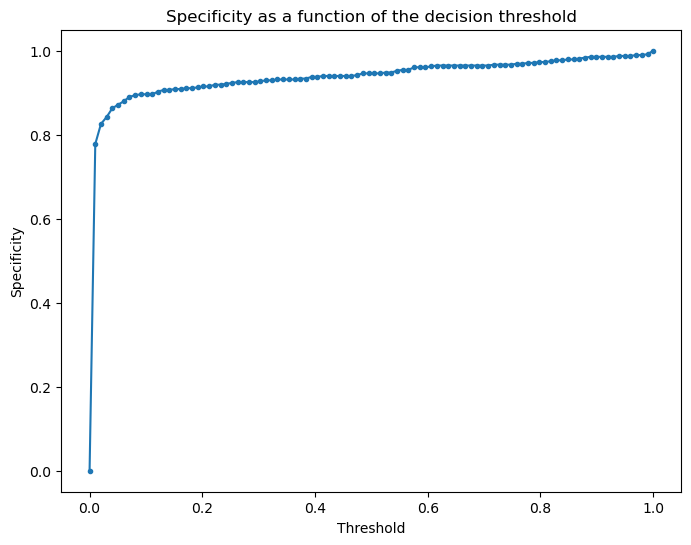

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       482
           1       0.95      0.97      0.96       478

    accuracy                           0.96       960
   macro avg       0.96      0.96      0.96       960
weighted avg       0.96      0.96      0.96       960

Sensitivity: 0.97
Specificity: 0.95
Precision: 0.95
Recall: 0.97
F1 Score: 0.96
AUC: 0.9925996979114221
Confusion Matrix:
[[456  26]
 [ 13 465]]
7/7 [==============================] - 0s 26ms/step - loss: 0.1225 - custom_accuracy: 0.9442 - precision: 0.9442 - recall: 0.9442


In [ ]:
model_path = model_path2_4
custom_objects={'weighted_cumulative_crossentropy': weighted_cumulative_crossentropy,'custom_accuracy': custom_accuracy}
true_labels, predicted_labels, predicted_probabilities = load_and_predict_model(model_path, test_generator, custom_objects)


plot_training_history(history2_4)

plot_roc_auc_curve(true_labels, predicted_probabilities)
plot_confusion_matrix(true_labels, predicted_labels)
plot_precision_recall_curve(true_labels, predicted_probabilities)

thresholds, f1_scores = calculate_f1_scores(true_labels, predicted_probabilities)
plot_f1_scores(thresholds, f1_scores)

thresholds, sensitivity_scores, specificity_scores = calculate_sensitivity_specificity(true_labels, predicted_probabilities)
plot_sensitivity(thresholds, sensitivity_scores)
plot_specificity(thresholds, specificity_scores)

print_classification_metrics(true_labels, predicted_labels, predicted_probabilities)


evaluation_result = Franklin_ensemble_model_2_using_new_loss.evaluate(test_generator, steps=7)